In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback,EarlyStoppingCallback,ReduceLROnPlateauCallback,OneCycleScheduler
import os
from fastai.metrics import *
from sklearn.model_selection import KFold
from radam import *
from csvlogger import *
from mish_activation import *
import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.59'

In [2]:
sz = 128
bs = 180
nfolds = 5 #keep the same split as the initial dataset
fold = 0
SEED = 2019
TRAIN = '../input/grapheme-imgs-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'
arch = models.densenet121
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data

In [3]:

df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.head()


[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
stats = ([0.0692], [0.2051])
from sklearn.model_selection import StratifiedKFold
tr_ids, val_ids = next(StratifiedKFold(n_splits=10).split(df.image_id, df.loc[:,['grapheme_root']]))
data = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idx(val_ids,)
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(size=sz, padding_mode='zeros',)
        .databunch(bs=bs)).normalize(stats)

#data.show_batch()

# Model

The starter model is based on DenseNet121, which I found to work quite well for such kind of problems. The first conv is replaced to accommodate for 1 channel input, and the corresponding pretrained weights are summed. ReLU activation in the head is replaced by Mish, which works noticeably better for all tasks I checked it so far. Since each portion of the prediction (grapheme_root, vowel_diacritic, and consonant_diacritic) is quite independent concept, I create a separate head for each of them (though I didn't do a comparison with one head solution).

In [5]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.5):
        super().__init__()
        layers = [AdaptiveConcatPool2d(), Mish(), Flatten()] + \
            bn_drop_lin(nc*2, 512, True, ps, Mish()) + \
            bn_drop_lin(512, n, True, ps)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

#change the first conv to accept 1 chanel input
class Dnet_1ch(nn.Module):
    def __init__(self, arch=arch, n=nunique, pre=True, ps=0.5):
        super().__init__()
        m = arch(True) if pre else arch()
        
        conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        w = (m.features.conv0.weight.sum(1)).unsqueeze(1)
        conv.weight = nn.Parameter(w)
        
        self.layer0 = nn.Sequential(conv, m.features.norm0, nn.ReLU(inplace=True))
        self.layer1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            m.features.denseblock1)
        self.layer2 = nn.Sequential(m.features.transition1,m.features.denseblock2)
        self.layer3 = nn.Sequential(m.features.transition2,m.features.denseblock3)
        self.layer4 = nn.Sequential(m.features.transition3,m.features.denseblock4,
                                    m.features.norm5)
        
        nc = self.layer4[-1].weight.shape[0]
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        #to_Mish(self.layer0), to_Mish(self.layer1), to_Mish(self.layer2)
        #to_Mish(self.layer3), to_Mish(self.layer4)
        
    def forward(self, x):    
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        
        return x1,x2,x3

# Loss

Cross entropy loss is applied independently to each part of the prediction and the result is summed with the corresponding weight.

In [6]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 2*F.cross_entropy(x1,y[:,0],reduction=reduction) + F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          F.cross_entropy(x3,y[:,2],reduction=reduction)

The code below computes the competition metric and recall macro metrics for individual components of the prediction. The code is partially borrowed from fast.ai.

In [7]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [8]:
#fix the issue in fast.ai of saving gradients along with weights
#so only weights are written, and files are ~4 times smaller

class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto',
                 every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": 
            #self.learn.save(f'{self.name}_{epoch}')
            torch.save(learn.model.state_dict(),f'{self.name}_{epoch}.pth')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                #print(f'Better model found at epoch {epoch} \
                #  with {self.monitor} value: {current}.')
                self.best = current
                #self.learn.save(f'{self.name}')
                torch.save(learn.model.state_dict(),f'{self.name}.pth')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and os.path.isfile(f'{self.name}.pth'):
            #self.learn.load(f'{self.name}', purge=False)
            self.model.load_state_dict(torch.load(f'{self.name}.pth'))

In [9]:
class CutMixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn, alpha=0.4, cutmix_alpha=1.0,cutmix_prob=0.5):
        super().__init__(learn)
        self.alpha = alpha
        self.cutmix_prob = cutmix_prob
        self.cutmix_alpha = cutmix_alpha

    def on_train_begin(self, **kwargs):
        self.learn.loss_func = MixLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train: 
            return

        # Implement cutmix
        if np.random.rand() < self.cutmix_prob:
            B, W, H = last_input.size(0), last_input.size(1), last_input.size(2)
            indices = torch.randperm(B)
            Lam = []
            last_input_ = last_input.clone()
            for i in range(B):
                lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
                cut_rat = np.sqrt(1. - lam)
                cut_w = np.int(W * cut_rat)
                cut_h = np.int(H * cut_rat)

                # uniform
                cx = np.random.randint(W)
                cy = np.random.randint(H)

                bbx1 = np.clip(cx - cut_w // 2, 0, W)
                bby1 = np.clip(cy - cut_h // 2, 0, H)
                bbx2 = np.clip(cx + cut_w // 2, 0, W)
                bby2 = np.clip(cy + cut_h // 2, 0, H)
                last_input[i, bbx1:bbx2, bby1:bby2] = last_input_[indices[i], bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                Lam.append(1 - (bbx2 - bbx1) * (bby2 - bby1) / (W * H))
            Lam = torch.tensor(Lam).cuda()
            new_input = last_input
            new_target = torch.cat([last_target.float(), last_target[indices].float(), Lam[:,None].float()], 1)
        else:
            lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
            lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
            lambd = last_input.new(lambd)
            shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
            # No stack x, compute x
            out_shape = [lambd.size(0)] + [1 for _ in range(len(last_input.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + last_input[shuffle] * (1-lambd).view(out_shape))
            # Stack y
            new_target = torch.cat([last_target.float(), last_target[shuffle].float(), lambd[:,None].float()], 1)
        return {'last_input': new_input, 'last_target': new_target}  

    def on_train_end(self, **kwargs):
        self.learn.loss_func = self.learn.loss_func.get_old()

class MixLoss(Module):
    "Adapt the loss function `crit` to go with mixup &amp; cutmix."
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3]), self.crit(output,target[:,3:6])
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  
            d = self.crit(output, target)

        if self.reduction == 'mean':    
            return d.mean()
        elif self.reduction == 'sum':   
            return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit


# MixUp

The code below modifies fast.ai MixUp calback to make it compatible with the current data.

In [10]:
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

# CutMix

from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks.mixup import MixUpLoss
from fastai.basic_train import Learner, LearnerCallback

class CutMixCallback(LearnerCallback):
    "Callback that creates the cutmixed input and target."
    def __init__(self, learn:Learner, α:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.α,self.stack_y,self.true_λ = α,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.α, self.α)
        λ = max(λ, 1- λ)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        #Get new input
        last_input_size = last_input.shape
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input.size(), λ)
        new_input = last_input.clone()
        new_input[:, ..., bby1:bby2, bbx1:bbx2] = last_input[shuffle, ..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        if self.true_λ:
            λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            λ = last_input.new([λ])
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, α:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add mixup https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, α=α, stack_y=stack_y, true_λ=true_λ))
    return learn


# Training

I have performed a check of different optimizers and schedules on a [similar task](https://www.kaggle.com/c/Kannada-MNIST/discussion/122430), and [Over9000 optimizer](https://github.com/mgrankin/over9000) cosine annealing **without warm-up** worked the best. Freezing the backbone at the initial stage of training didn't give me any advantage in that test, so here I perform the training straight a way with discriminative learning rate (smaller lr for backbone).

In [11]:
os.listdir('../input/densenet121v6')


['best_weights_densenet121_epoch (1).pth']

In [12]:

model = Dnet_1ch()
learn = Learner(data, model, loss_func=Loss_combine(), opt_func=Over9000,model_dir='/kaggle/input/densenet121v7',
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()])
logger = CSVLogger(learn,f'log{fold}')
learn.clip_grad = 1.0
learn.split([model.head1])
learn = learn.load('/kaggle/input/densenet121v7/best_weights_densenet121_epochv3_3')
#learn=cutmix(learn)
learn.unfreeze()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 196MB/s]


In [13]:
learn.fit_one_cycle(4,max_lr=slice(1e-2,1e-6), callbacks = [logger, SaveModelCallback(learn,name='best_weights_densenet121_epochv3',every='epoch',monitor='valid_loss'),
                                 EarlyStoppingCallback(learn,monitor='valid_loss',min_delta=1e-5,patience=10),
                                 ReduceLROnPlateauCallback(learn,monitor='valid_loss',min_lr=1e-12,patience=5,min_delta=1e-4,factor=0.5)])
#,CutMixUpCallback(learn)])
#metrics: Metric_grapheme, Metric_vowel, Metric_consonant, Metric_tot (competition metric)


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.127291,0.427047,0.955560,0.983911,0.981506,0.969135,10:00
1,0.155279,0.450000,0.949859,0.979157,0.982738,0.965403,09:06
2,0.073375,0.456044,0.958579,0.984948,0.985418,0.971881,09:03
3,0.036140,0.471418,0.961992,0.984359,0.984694,0.973259,09:03


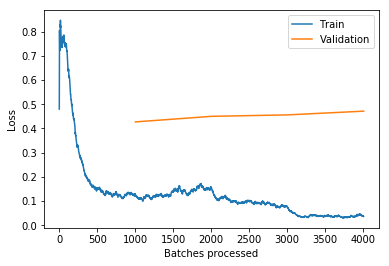

In [14]:
learn.recorder.plot_losses()

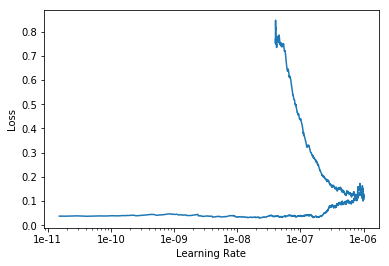

In [15]:
learn.recorder.plot()

In [16]:
learn.export()